In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [19]:
import os

print("working path =", os.getcwd())
os.chdir('/mnt/f/LiveTalking/wav2lip/')
print("working path =", os.getcwd())

working path = /mnt/f/LiveTalking
working path = /mnt/f/LiveTalking/wav2lip


In [20]:
import face_detection

In [36]:
from os import listdir, path
import numpy as np
import scipy, cv2, os, sys, argparse
import json, subprocess, random, string
from tqdm import tqdm
from glob import glob
import torch
import pickle
import face_detection


def video2imgs(vid_path, save_path, ext = '.png',cut_frame = 10000000):
    cap = cv2.VideoCapture(vid_path)
    count = 0
    while True:
        if count > cut_frame:
            break
        ret, frame = cap.read()
        if ret:
            cv2.putText(frame, "LiveTalking", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (128,128,128), 1)
            cv2.imwrite(f"{save_path}/{count:08d}.png", frame)
            count += 1
        else:
            break

def read_imgs(img_list):
    frames = []
    print('reading images...')
    for img_path in tqdm(img_list):
        frame = cv2.imread(img_path)
        frames.append(frame)
    return frames

def get_smoothened_boxes(boxes, T):
	for i in range(len(boxes)):
		if i + T > len(boxes):
			window = boxes[len(boxes) - T:]
		else:
			window = boxes[i : i + T]
		boxes[i] = np.mean(window, axis=0)
	return boxes

def face_detect(images):
	detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, 
											flip_input=False, device='cuda')

	batch_size = 1
	
	while 1:
		predictions = []
		try:
			for i in tqdm(range(0, len(images), batch_size)):
				predictions.extend(detector.get_detections_for_batch(np.array(images[i:i + batch_size])))
		except RuntimeError:
			if batch_size == 1: 
				raise RuntimeError('Image too big to run face detection on GPU. Please use the --resize_factor argument')
			batch_size //= 2
			print('Recovering from OOM error; New batch size: {}'.format(batch_size))
			continue
		break

	results = []
	pady1, pady2, padx1, padx2 = args.pads
	for rect, image in zip(predictions, images):
		if rect is None:
			cv2.imwrite('temp/faulty_frame.jpg', image) # check this frame where the face was not detected.
			raise ValueError('Face not detected! Ensure the video contains a face in all the frames.')

		y1 = max(0, rect[1] - pady1)
		y2 = min(image.shape[0], rect[3] + pady2)
		x1 = max(0, rect[0] - padx1)
		x2 = min(image.shape[1], rect[2] + padx2)
		
		results.append([x1, y1, x2, y2])

	boxes = np.array(results)
	if not args.nosmooth: boxes = get_smoothened_boxes(boxes, T=5)
	results = [[image[y1: y2, x1:x2], (y1, y2, x1, x2)] for image, (x1, y1, x2, y2) in zip(images, boxes)]

	del detector
	return results 

# if __name__ == "__main__":
#     avatar_path = f"./results/avatars/{args.avatar_id}"
#     full_imgs_path = f"{avatar_path}/full_imgs" 
#     face_imgs_path = f"{avatar_path}/face_imgs" 
#     coords_path = f"{avatar_path}/coords.pkl"
#     osmakedirs([avatar_path,full_imgs_path,face_imgs_path])
#     print(args)

#     #if os.path.isfile(args.video_path):
#     video2imgs(args.video_path, full_imgs_path, ext = 'png')
#     input_img_list = sorted(glob(os.path.join(full_imgs_path, '*.[jpJP][pnPN]*[gG]')))

#     frames = read_imgs(input_img_list)
#     face_det_results = face_detect(frames) 
#     coord_list = []
#     idx = 0
#     for frame,coords in face_det_results:        
#         #x1, y1, x2, y2 = bbox
#         resized_crop_frame = cv2.resize(frame,(args.img_size, args.img_size)) #,interpolation = cv2.INTER_LANCZOS4)
#         cv2.imwrite(f"{face_imgs_path}/{idx:08d}.png", resized_crop_frame)
#         coord_list.append(coords)
#         idx = idx + 1
	
#     with open(coords_path, 'wb') as f:
#         pickle.dump(coord_list, f)

In [28]:
frames = read_imgs(["../data/avatars/wav2lip384_avatar2/full_imgs/00000000.png"])

reading images...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.50it/s]


In [29]:
print(frames[0].shape)

(1038, 1920, 3)


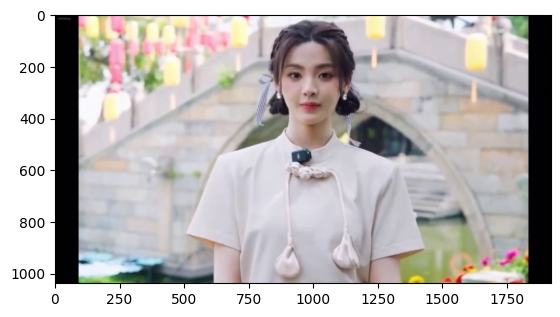

In [32]:
import matplotlib.pyplot as plt 

c = plt.imshow(frames[0][:,:,[2,1,0]]) 

In [38]:
results = face_detect(frames)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.13s/it]


NameError: name 'args' is not defined